#### Курсовой проект по по курсу "Python для Data Science"

#### Cлушатель: Перфильев Дмитрий

#### Задание:

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


#### Решение:

Загружаем необходимые библиотеки. Устанавливаем настройки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score as r2

style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Загрузим данные из файла data_train.csv по которым построим модель. 

In [2]:
data_train = pd.read_csv('DATA/train.csv', sep=',')
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


Вспомагательные функции

In [3]:
def mean_group(data,name_col):
    return data.loc[data[name_col],name_col].mean()

In [4]:
def ratio(x, y):
    if y == 0:
        return print(f'Делитель = 0')
    return x / y

Разобьем данные на тренеровочные (data_train) на которых будем обучать модель и на валидационные (valid) по которым будем предскаpывать цену и оценивать модель

In [5]:
####train, valid = tts(data_data_train, test_size=0.3, random_state=22)
####train.shape, valid.shape

Оценим качество данных. Произведем первичную обработку данных.

Оценим количество отсутствующих полей

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


Поле Healthcare_1 имеет значительное количество пропущенных полей почти половины от общего числа (3666 из 7000) имеет смысл удалить данный признак из данных. Если модель без данного признака не будет показывать положительных результатов постараемся восстановить денный признак.

In [7]:
data_train = data_train.drop('Healthcare_1', axis=1)

In [8]:
data_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570


Преобразуем категориальные признаки Ecology_2 Ecology_3  

In [9]:
data_train = pd.get_dummies(data_train)

In [10]:
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2,4,150226.531644,0,1,0,1,0,1


In [11]:
data_train.shape

(10000, 22)

Преобразуем поле HouseYear - вычислим возраст домов


In [12]:
data_train.loc[2019 - data_train['HouseYear'] < 0,'HouseYear']

585         2020
707         2020
790         2020
918         2020
1497    20052011
1499        2020
2493        2020
2877        2020
3357        2020
3485        2020
3859        2020
4053        2020
4189        4968
4376        2020
4493        2020
5701        2020
6735        2020
7076        2020
7459        2020
8253        2020
9674        2020
Name: HouseYear, dtype: int64

In [13]:
data_train.loc[data_train['HouseYear'] == 20052011,'HouseYear'] = 2011
data_train.loc[data_train['HouseYear'] == 4968,'HouseYear'] = 1968

In [14]:
data_train.loc[2019 - data_train['HouseYear'] < 0,'HouseYear']

585     2020
707     2020
790     2020
918     2020
1499    2020
2493    2020
2877    2020
3357    2020
3485    2020
3859    2020
4053    2020
4376    2020
4493    2020
5701    2020
6735    2020
7076    2020
7459    2020
8253    2020
9674    2020
Name: HouseYear, dtype: int64

In [15]:
data_train.loc[2019 - data_train['HouseYear'] > 100,'HouseYear']

910     1914
1380    1917
1386    1918
2554    1918
2656    1912
2902    1918
5016    1918
5053    1917
5111    1912
7611    1916
8144    1917
8505    1918
9317    1910
Name: HouseYear, dtype: int64

In [16]:
data_train['HouseYear'] = 2019 - data_train['HouseYear']

In [17]:
data_train['HouseYear'].describe()

count    10000.000000
mean        34.133700
std         18.412271
min         -1.000000
25%         18.000000
50%         42.000000
75%         45.000000
max        109.000000
Name: HouseYear, dtype: float64

Оценим данные в колнках Rooms Square LifeSquare KitchenSquare

Выберем все данные с коректными данными

In [18]:
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,50,0.089040,...,5,0,11,184966.930730,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,41,0.000070,...,1,1,16,300009.450063,0,1,0,1,0,1
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,51,0.049637,...,0,1,3,220925.908524,0,1,0,1,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,42,0.437885,...,3,0,5,175616.227217,0,1,0,1,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,43,0.012339,...,1,2,4,150226.531644,0,1,0,1,0,1


Заменим пустые поля колонки LifeSquare значениями поля колонки Square

In [19]:
data_train['LifeSquare'] = data_train['LifeSquare'].fillna(data_train['Square'])

In [20]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,42.091874,6.273300,214138.857399
std,0.839512,21.058732,77.880874,28.560917,92872.293865
min,0.000000,1.136859,0.370619,0.000000,59174.778028
25%,1.000000,41.774881,25.506959,1.000000,153872.633942
50%,2.000000,52.513310,37.562685,6.000000,192269.644879
75%,2.000000,65.900625,50.098049,9.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,633233.466570


In [21]:
data_train.loc[(data_train['LifeSquare'] > 200) | 
                (data_train['Square'] > 200),:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,47,0.075779,...,3,0,2,141780.231857,0,1,0,1,0,1
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,11,0.211401,...,0,0,1,302211.260887,0,1,0,1,0,1
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,8,0.161976,...,5,3,7,455264.882666,0,1,1,0,0,1
4262,28,9,2.0,604.705972,604.705972,1.0,17,18.0,42,0.161532,...,1,2,4,187717.242538,0,1,0,1,0,1
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,3,0.017647,...,0,0,0,217357.492366,0,1,0,1,0,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,3,0.238617,...,6,3,6,90470.430830,0,1,0,1,0,1
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,0,0.000078,...,141,3,23,133529.681562,0,1,0,1,0,1
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,21,0.037178,...,1,1,7,394253.299978,0,1,0,1,0,1
9910,16568,27,4.0,200.334539,201.627361,25.0,1,2.0,6,0.041116,...,4,1,4,528560.506016,0,1,0,1,0,1


In [31]:
data_train.loc[(data_train['LifeSquare'] < 10) | 
                (data_train['Square'] < 10),:].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,1,0.072158,...,1,0,0,337299.867936,0,1,0,1,1,0
95,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,5,0.069753,...,4,1,11,286564.441972,0,1,0,1,0,1
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,42,0.243205,...,0,0,0,180727.643541,0,1,0,1,0,1
158,16779,27,3.0,51.991064,4.896202,1.0,22,25.0,42,0.072158,...,1,0,0,174687.566186,0,1,0,1,1,0
160,3522,6,1.0,66.419841,3.987101,1.0,2,1.0,42,0.243205,...,0,0,0,193361.229815,0,1,0,1,0,1


In [23]:
data_train.loc[data_train['LifeSquare'] > 7000,'LifeSquare'] = data_train['Square'] 

In [24]:
data_train['Square'].mean()/data_train['Rooms'].mean()

29.7888258121849

In [25]:
df_class = data_train.loc[(~data_train['LifeSquare'].isnull()) & 
               (data_train['Rooms'] > 0) & 
               (data_train['LifeSquare'] < data_train['Square']) & 
                (data_train['Floor'] < data_train['HouseFloor']),:].copy()

df_class.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,...,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000,5574.000000
mean,8399.838357,57.675637,1.921421,54.807897,34.297103,7.601722,7.251704,13.539290,33.026911,0.123548,...,6.617330,1.564227,4.633297,226995.747811,0.010585,0.989415,0.036778,0.963222,0.067456,0.932544
std,4840.041510,45.506381,0.825702,18.097826,15.124307,4.175407,4.591355,5.690298,18.715671,0.120549,...,17.305961,1.516729,4.266437,94867.093440,0.102346,0.102346,0.188233,0.188233,0.250833,0.250833
min,0.000000,0.000000,1.000000,16.117154,1.049867,0.000000,1.000000,2.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4243.750000,21.000000,1.000000,41.110873,22.538021,6.000000,4.000000,9.000000,16.000000,0.033494,...,1.000000,0.000000,1.000000,165636.174754,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8370.500000,47.000000,2.000000,50.831419,32.076601,8.000000,6.000000,14.000000,37.000000,0.089040,...,2.500000,1.000000,4.000000,203264.805697,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12603.500000,90.000000,3.000000,64.471629,43.679753,9.000000,10.000000,17.000000,48.000000,0.194489,...,5.000000,3.000000,6.000000,269092.536067,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.000000,207.000000,6.000000,275.645284,233.949309,84.000000,42.000000,99.000000,109.000000,0.521867,...,141.000000,6.000000,23.000000,625678.644994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
df_class = df_class.loc[(df_class['Rooms'] > df_class['Square']/df_class['Square'].mean()/df_class['Rooms'].mean()) &
             (df_class['Square'] > df_class['Rooms'] * df_class['Square'].mean()/df_class['Rooms'].mean()),:]

In [27]:
df_class.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,43,0.012339,...,1,2,4,150226.531644,0,1,0,1,0,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,59,0.460556,...,14,1,5,296021.204377,0,1,0,1,0,1
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,5,0.075779,...,3,0,2,95380.220993,0,1,0,1,0,1
17,3000,34,2.0,57.969964,32.012483,9.0,6,14.0,18,0.069753,...,4,1,11,231828.437667,0,1,0,1,0,1
18,2829,57,1.0,44.513481,23.113423,8.0,6,12.0,36,0.133215,...,3,3,4,183743.230464,0,1,0,1,1,0


In [34]:
data_train.groupby('Rooms').mean()

,Id,DistrictId,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
Rooms,,,,,,,,,,,,,,,,,,,,,
0.0,5615.500000,32.125000,81.620358,78.194525,1.125000,6.750000,4.625000,27.875000,0.152049,14.750000,...,0.500000,0.500000,1.500000,200435.886261,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1.0,8406.774629,47.137652,41.323277,29.642806,6.525776,8.684480,13.077463,32.214305,0.122414,23.470175,...,7.272874,1.202159,3.983266,159850.800729,0.008637,0.991363,0.023482,0.976518,0.087449,0.912551
2.0,8399.308763,50.762371,56.788214,42.101406,5.636340,8.262113,12.151289,36.156959,0.119468,24.516753,...,8.944845,1.363402,4.244072,215256.306416,0.011856,0.988144,0.032990,0.967010,0.070876,0.929124
3.0,8351.163758,53.723937,76.903234,57.121500,6.801790,8.766443,12.729754,33.837136,0.112118,26.510962,...,7.561521,1.412975,4.512304,289337.962452,0.006711,0.993289,0.025503,0.974497,0.097987,0.902013
4.0,8311.353333,70.900000,98.377544,68.611430,8.506667,8.040000,11.913333,33.800000,0.117009,31.586667,...,11.400000,1.660000,5.753333,383251.100956,0.026667,0.973333,0.006667,0.993333,0.040000,0.960000
5.0,5438.611111,70.777778,122.614941,90.046888,9.222222,7.333333,9.444444,37.666667,0.102776,28.555556,...,6.777778,1.666667,5.555556,410431.605679,0.000000,1.000000,0.111111,0.888889,0.055556,0.944444
6.0,14003.000000,99.000000,59.414334,38.702244,6.000000,7.000000,9.000000,50.000000,0.033494,66.000000,...,1.000000,3.000000,8.000000,229661.964416,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
10.0,10396.000000,33.000000,59.964120,37.321877,10.000000,12.500000,12.000000,21.000000,0.126165,49.500000,...,1.500000,3.500000,9.500000,244797.297328,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
19.0,8491.000000,1.000000,42.006046,21.779288,7.000000,17.000000,17.000000,5.000000,0.007122,1.000000,...,0.000000,0.000000,1.000000,78364.616704,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


In [36]:
data_train.loc[data_train['Rooms'] == 19,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,5,0.007122,...,0,0,1,78364.616704,0,1,0,1,0,1


In [46]:
data_train.groupby(['DistrictId']).mean()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
DistrictId,,,,,,,,,,,,,,,,,,,,,
0,8302.979167,1.770833,54.549887,34.133694,7.208333,6.791667,12.125000,33.687500,2.086955e-01,26.770833,...,10.333333,5.354167,7.291667,195295.590075,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,8124.717791,1.831288,59.147410,54.666506,2.736196,10.395706,16.564417,33.638037,9.185492e-03,3.164110,...,0.039877,0.213190,0.990798,187805.401737,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2,8483.435897,1.910256,53.870293,32.707890,8.307692,6.500000,10.435897,42.282051,1.376130e-01,36.858974,...,4.076923,0.692308,5.717949,243688.618402,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
3,8049.158537,1.756098,50.138363,30.640976,7.304878,7.841463,12.036585,39.402439,1.185811e-01,40.914634,...,0.731707,2.317073,2.695122,179905.016194,0.000000,1.000000,0.012195,0.987805,0.000000,1.000000
4,10583.181818,2.363636,66.822950,44.107076,7.636364,5.272727,9.818182,49.090909,1.898508e-01,20.636364,...,61.090909,1.636364,5.545455,300096.687440,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
5,9193.500000,1.794118,49.030885,34.448479,5.500000,6.441176,12.382353,40.000000,1.508175e-01,16.000000,...,4.000000,4.000000,5.000000,238650.600802,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
6,8244.236791,1.759295,57.950584,49.542094,2.651663,10.972603,16.393346,28.181996,2.432045e-01,5.000000,...,0.000000,0.000000,0.000000,166127.145161,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
7,8370.576087,2.021739,54.696860,33.097854,7.869565,8.195652,12.119565,35.923913,9.003746e-02,39.619565,...,6.554348,0.652174,6.619565,243154.833226,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
8,9000.647887,1.901408,53.583465,32.699919,7.626761,7.922535,13.281690,31.838028,3.489061e-01,24.802817,...,1.950704,0.781690,4.302817,214455.071993,0.000000,1.000000,0.436620,0.563380,0.000000,1.000000


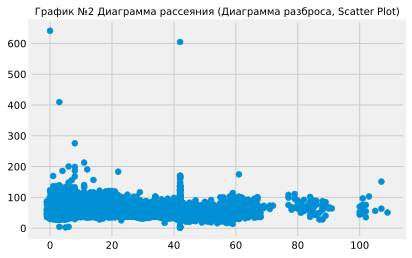

In [28]:
plt.scatter(data_train['HouseYear'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [29]:
from sklearn.cluster import AgglomerativeClustering

In [30]:
return

SyntaxError: 'return' outside function (<ipython-input-30-9b32c1431b19>, line 1)

In [ ]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

In [ ]:
data_train.loc[data_train['Square'] < data_train['LifeSquare'],['Square','LifeSquare']].head()

Поменняем местами поля колонок LifeSquare и Square там где Square < LifeSquare

In [ ]:
# life_square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'LifeSquare'].copy()
# square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Square'].copy()

# id_sq = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Id']

# (data_train.loc[id_sq.index,'Square'] , data_train.loc[id_sq.index,'LifeSquare']) = (life_square, square)

Выберем и обработаем колонку Rooms с нулевым значением. 

In [ ]:
data_train.loc[data_train['Rooms'] == 0,['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']]

In [ ]:
data_train.loc[data_train['Rooms'] == 0,'Rooms'] = round(data_train['Square'] / (data_train.loc[data_train['Rooms'] != 0,'Square']/data_train.loc[data_train['Rooms'] != 0,'Rooms']).mean())

Заменим данные в строке 4853 средними значениями 

In [ ]:
data_train.loc[4853,['Rooms','Square','LifeSquare']] = [round(data_train['Rooms'].std()) , 
                                                        data_train['Square'].std(),
                                                        data_train['LifeSquare'].std()]

In [ ]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

Построим диаграммы для оценки данных

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

Отсечем экстремальные значения

In [ ]:
data_train.loc[(data_train['Rooms'] == 3) & (data_train['Square'] > 7000),:] 

In [ ]:
data_train.loc[(data_train['Rooms'] == 3) & (data_train['Square'] > 7000),'Square'] = data_train['LifeSquare']
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Square'] > data_train['Rooms'] * 80,'Square'] = data_train['Rooms'] * 80

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Rooms'] == 5, :]

In [ ]:
data_train.loc[data_train['Square'] < data_train['Rooms'] * 20, 'Square'] = data_train['Rooms'] * 30
data_train.loc[data_train['Square'] < data_train['Rooms'] * 20, 'Square'] = data_train['Rooms'] * 30

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Rooms'] == 5, :]

In [ ]:
data_train.loc[(data_train['Rooms'] == 1) & (data_train['Square'] > 100),:] 

In [ ]:
plt.scatter(data_train['Rooms'],data_train['LifeSquare'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
data_train.loc[data_train['Square'] == max(data_train['Square']),:]

In [ ]:
# data_train.loc[data_train['Rooms'] > raund(data_train['Rooms']/Square]

In [ ]:
data_train.loc[data_train['Square'] < data_train['LifeSquare'],:].head()

In [ ]:
life_square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'LifeSquare'].copy()
square = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Square'].copy()

id_sq = data_train.loc[data_train['Square'] < data_train['LifeSquare'],'Id']

(data_train.loc[id_sq.index,'Square'] , data_train.loc[id_sq.index,'LifeSquare']) = (life_square, square)

In [ ]:
data_train[['Rooms','Square','LifeSquare', 'KitchenSquare', 'Price']].describe()

In [ ]:
data_train.loc[153]

In [ ]:
data_train.loc[data_train['Square'] > data_train['Rooms'] * data_train['Square'].mean(),'Rooms']

In [ ]:
data_train.loc[data_train['Rooms'] > 3,:]

In [ ]:
data_train.loc[data_train['HouseYear'] < 0, :]

In [ ]:
data_train.loc[data_train['HouseYear'] > 100, :]

In [ ]:
data_train['Ecology_3'].value_counts()

In [ ]:
df_test = pd.read_csv('DATA/test.csv', sep=',')
df_data_train.head()
df_data_train['Ecology_2'].value_counts()

In [ ]:
data_train.loc[data_train['LifeSquare'].isnull(),:].head()

In [ ]:
data_train.describe()

In [ ]:
data_train.loc[data_train['Healthcare_1'].isnull(),:].head()

In [ ]:
df_test = pd.read_csv('DATA/test.csv', sep=',')
df_data_train.head()

In [ ]:
df_test.head()

In [ ]:
df_data_train.info()

In [ ]:
df_data_train.columns

In [ ]:
df_target_data_train = pd.DataFrame(df_data_train['Price'], columns=['Price'])

In [ ]:
df_target_data_train.head()

In [ ]:
df_data_train.describe()